<a href="https://colab.research.google.com/github/Shahriad50/tfmodel/blob/main/endoscopy_multiClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification des anomalies gastro-intestinaux par imagerie endoscopique avec apprentissage en profondeur**


Dans cette étude nous avons utilisé l'imagerie endoscopique du tractus gastro-intestinal humain afin de détecter différents types d'anomalies. Nous avons utilisé l'ensemble de données `KVASIR` pour cette tâche ainsi qu'un réseau de neurones convolutifs.

L'ensemble de données `KVASIR` se compose de 4 000 images annotées du tractus gastro-intestinal dans 8 classes différentes (différentes anomalies), chaque classe comporte 500 images.

Les 8 classes d'anomalies:
- dyed-lifted-polyps
- normal-cecum
- normal-pylorus
- normal-z-line
- esophagitis
- polyps
- ulcerative colitis
- dyed-resection-margins

## **Bibliothèques requis**
Ici on importer l'ensemble des bibliothèques requis

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pour divisez les donnees en sous-ensembles d'entraînement et de test aléatoires.
from sklearn.model_selection import train_test_split

# pour calculer la matrice de confusion
from sklearn.metrics import confusion_matrix

# pour réduisez le taux d'apprentissage lorsqu'une métrique a cessé de s'améliorer.
from keras.callbacks import ReduceLROnPlateau

# pour pouvoir importer utiliser le modèle pré-entraîner VGG19
from tensorflow.keras.applications import VGG19

# pour convertit le vecteur (y) de classe (entiers) en matrice de classe binaire.
from tensorflow.keras.utils import to_categorical

# pour générer des images altere
from keras.preprocessing.image import ImageDataGenerator

# pour initialise le methode de le desente gradien
from tensorflow.keras.optimizers import SGD, Adam

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout


#### **Demande de suppression du model sauvegardé**:
Comme l'apprentissage prend du temps on a sauvegardé le model, on peut le supprimer pour reprendre l'apprentissage du model a 0.

Si on répond à la demande de suppression par:
- entre `Y`: pour suppression du model
- n'importe quel caractère: ne pas supprimer

In [ ]:
if os.path.isdir("./saved_model"):
    try:
        strr= input('delete saved model? Y/N')
        if strr == 'Y' or strr == 'y':
            !rm -rf "./saved_model"
            print("deleted model")
        else:
            print('the old model will be used')
    except:

        pass

the old model will be used


## **1. Configurer le dataset**

### **1.1. Telecharger le dataset**
Ici on vérifie l'environnement d'exécution du notebook (`Google Colab` ou `kaggle`), pour éviter de télécharger le dataset en local car sa taille dépasse les 1Gb.

Pour ce faire on utilise une des platforme (`Google Colab` ou `kaggle`) pour exécuter notebook sans télécharge le dataset sur notre machine.

Par ailleurs `Google Colab` et `Kaggle` offre l'option d'exécution avec GPU, ce qui accélérer considérablement les opérations d'apprentissage automatique.


In [ ]:
"""
    Les fonctions utilise pour recupere le dataset
"""

# ----------------------------------------------------------------------
def in_colab():
    """
        détecter si le notebook s'exécute sur colab

    Returns:
        booleen: vrai ou faux
    """
    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB


# -----------------------------------------------------------------------
def in_kaggle():
    """
        détecter si le notebook s'exécute sur Kaggle

    Returns:
        booleen: vrai ou faux
    """
    import os

    return os.path.isdir("../input") and os.path.isdir("/kaggle/working")


# -------------------------------------------------------------------------
def download_dataset(URL, dataset_name):
    """
        telecharge le dataset ddepuis un lien donné

    Args:
        URL (str): le lien pour telecherge le dataset
        dataset_name (str): le nom du dataset (kvasir-dataset)

    Returns:
        str: le chemin du dataset telecharger
    """ """"""
    import tensorflow as tf
    import os

    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path


Procède:
- si on est sur colab, on télécharger le dataset depuis le lien suivent (https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip).
  Le telechargement ne prendra que quelques secondes vu que le telechargment s'effectue sur le serveur de `Google Colab`
- si on est sur kaggel, le dataset sera accessible depuis le chemin suivent `../input/kvasir-dataset/kvasir-dataset`
- si on est-on local, le dataset sera accessible depuis le chemin suivent `./kvasir-dataset` vu qu'ont l'a déjà téléchargé

In [ ]:
# si on est sur colab
if in_colab():
    # si le dataset n'exist pas
    if not os.path.isdir("/root/.keras/datasets/kvasir-dataset"):
        URL = f"https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"
        dataset_dir = download_dataset(URL, "kvasir-dataset")

elif in_kaggle():
    dataset_dir = "../input/kvasir-dataset/kvasir-dataset"

else:
    dataset_dir = "./kvasir-dataset"

print(f"les dataset est dispo: {dataset_dir}")

les dataset est dispo: ./kvasir-dataset


### **1.2. Definier les categories du dataset**
Ici on définit les catégories (classes) du dataset a partir des noms de dossiers du dataset.
Le dataset se compose de 8 dossiers (un pour chaque classe) nommer suivent leur catégorie, chaque dossier comporte 500 images.

In [ ]:
def get_dataCategories(dataset_dir):
    """
        optenire les categories (classe) du dataset a partire du chemin du dataset
        en question.

    Args:
        dataset_dir (str): chemin du dataset

    Returns:
        list: liste des categories
        list: liste des nombre de fichier par categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])




categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df


number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


### **1.3. Cree l'ensmble des features X ainsi que les labels y**
pour ce faire on lit chaque image du dataset et on la met dans `X`, et on sauvegarde la classe de l'image lue dans `y`.

**Remarque**: on redimensionne les images lues en 100x100 pour accélérer l'étape d'apprentissage


In [ ]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        lit les images du dataset et les redimensionner en utilisent les dimensions
        (img_wid x img_high ) pour cree l'ensmble des features X ainsi que les labels y

    Args:
        datadir (str): chemin du dataset
        categories (str): les different classes du dataset
        img_wid (int): custom width
        img_high (int): custom height

    Returns:
        X(numpy): l'ensmble des features (i.e: comporte toute les images lu)
        y(numpy): l'ensmble des labels (i.e: comporte les categorie de chaque image de X)
    """

    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y




img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")


X: (4000, 100, 100, 3)
y: (4000,)


### **1.4. Afficher une image aléatoire pour chaque catégorie**
On affiche pour chaque classe une image au hasard

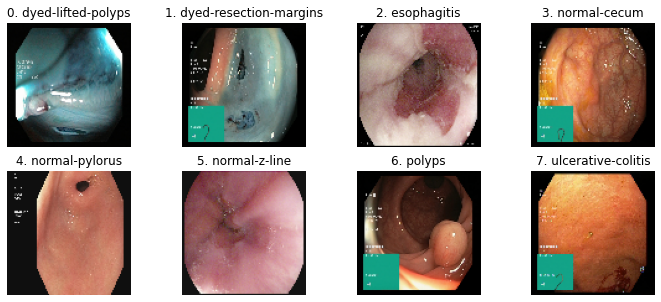

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()


## **2. Créations du model et apprentissage**

### **2.1. Cree l'ensemble d'apprentissage, test et de validation**
Dans cette etap on cree:
- l'ensemble d'entrainement `x_train`/`y_taine`
- l'ensemble de test `x_test`/`y_test`
- l'ensemble de validation `x_val`/`y_va`

#### **2.1.1. L'ensemble d'entrainment `(X/y)train` et de test `(X/y)test`**
On divise les données (X, y) en ensemble d'entrainement et de test en utilisant 80 % des données pour l'apprentissage et les 20 % restants pour les tests.

In [ ]:
# en convertie y en format scaler
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


#### **2.1.2. Cree l'ensemble de validation `x_val/y_val`**

Ici, nous on divise 30% de l'ensemble d'entrainement en ensemble de validation

In [ ]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")


x_train:(2300, 100, 100, 3),  y_train:(2300, 1)
x_train:(900, 100, 100, 3),  y_train:(900, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


#### **2.1.3. Encodage à chaud (OneHot Encoding)**

Nous devons faire un encodage à chaud (OneHot Encoding) avec `to_categorical`, pour transformer l'ensemble des lables (`y_train`, `y_val` et `y_test`) de tel sorte à avoir un vecteur pour chaque exemple, car nous avons 8 classes et nous devrions nous attendre à ce que la forme de (`y_train`, `y_val` et `y_test`) passe de 1 à 8

In [ ]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2300, 100, 100, 3),  y_train:(2300, 8)
x_train:(900, 100, 100, 3),  y_train:(900, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


### **2.2. Generation d'images**

Ici, nous allons effectuer l'augmentation des données d'image. Il s'agit de la technique utilisée pour augmenter la taille d'un ensemble de données d'apprentissage en créant des versions modifiées d'images dans l'ensemble de données. La création de ces images modifié s'effectue en pivotent de manière aléatoire ces images de n'importe quel degré entre 0 et 360.

Tout d'abord, nous définirons des instances individuelles d'ImageDataGenerator pour l'augmentation, puis nous les adapterons à chacun des ensembles de données d'entraînement, de test et de validation.

In [ ]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)


### **2.3. Telecharge le model pré-entraîné VGG19**

Maintenant, nous allons instancier le model `VGG19` qui est un réseau de neurones convolutif pré-entraîné en tant que modèle d'apprentissage par transfert.

Le plus grand avantage de ce réseau est que il a été pre-entraîné sur plus d'un million d'images de la base de données ImageNet.

Un réseau pré-entraîné peut classer les images en milliers de catégories d'objets. En raison de cet avantage, nous allons appliquer ce modèle sur notre dataset qui comporte 8 catégories, en lui ajoutent d'autre couches.

In [ ]:
# si il a deja ete cree et sauvgarde --> lire le model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    # load model
    base_model = load_model("./saved_model/vgg19_model.h5")

# si il n'a pas deja ete cree --> cree le model er le saugrade
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

Nous allons maintenant définir `VGG19` comme une architecture d'apprentissage profond. Pour cela, il sera défini comme un modèle séquentiel de Keras à plusieurs couches denses.

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

Maintenant, pour ajouter d'autres couches, nous devons voir la dimension de notre modèle.

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


Ajouter des couches dense avec l'activation et la normalisation par lots

In [ ]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

Verification du model final

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

### **2.4. Hyperparametrage**

Les hyperparamètres sont des paramètres réglables qui nous permettent de contrôler le processus d'entraînement du modèle. Les performances du modèle dépendent fortement des hyperparamètres.

Comme nous avons défini notre modèle, nous devons maintenant initialiser les hyperparamètres nécessaires pour former le modèle, puis enfin, nous allons compiler notre modèle.

In [ ]:
""" Initializing the hyperparameters """

# initialise le nombre d'échantillons d'apprentisage
batch_size = 100

# initialise le nombre d'iteration
epochs = 50

# taux d'apprentisage
learn_rate = 0.001

# initilisation de la descente du gradient
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# initilisation de la descente du gradient Adam
# adam = Adam( learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# compiler le model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])



La reduction de taux d'apprentissage diminue le taux d'apprentissage après un certain nombre d'iteration si le taux d'erreur ne change pas. Ici, grâce à cette technique, nous surveillerons la précision de la validation et si cela cessé de s'améliorer on réduira le taux d'apprentissage de 0,01.

In [ ]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

### **2.5. Entrainement du le model**

Maintenant, nous commençons à former notre model.

In [ ]:
# si model a ete deja entrainer et sauvgarde ---> lire le model
if os.path.isfile("./saved_model/model.h5"):

    # lire le model
    model = load_model("./saved_model/model.h5")

    # si l'historique du model a ete sauvgarde --> lire l'historique
    if os.path.isfile("./saved_model/model_history.npy"):

        # lire l'historique
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# si le model n'a pas ete deja entrainer --> entrainer le model
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history.history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")


## **3. Evaluation du model**

### **3.1. Evaluer la précision sur l'ensemble de test**

Evaluer la précision ainsi que la perte du model sur l'ensemble de test

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))


Test loss: 0.337
Test accuracy: 0.938


### **3.2. Matrice de confusion**

Enfin, nous visualiserons les performances de classification sur des données de test à l'aide de matrices de confusion.

In [ ]:
"""
    Les fonctions utilise affiche la matrice de confusion
"""

# ----------------------------------------------------------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
       affiche la matrice de confusion appartire de l'ax entre

    Args:
        ax (plt): ax qui sert a affiche la matrice
        cm (numpy): matrice de confusion
        classes (list): liste des classes
        cmap (plt): couluer de la matrice
        title (str): titre de la matrice
        normalize (booleen): vrai affichre cm normalisee

    Returns:
        plt: l'ax qui sera affiche
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ----------------------------------------------------------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
        afficher la cm normalisee et non normalisee

    Args:
        cm (numpy): matrice de confusion
        classes (list): liste des classes
        fig_size (_type_): _description_
        cmap (plt, optional): couluer de la matrice. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )


Prédir les classes de l'ensemble de test

In [ ]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)


Affiche la matrice de confusion normalisée et non normalisée.

Nous verrons le nombre exact de classifications correctes et incorrectes à l'aide de la matrice de confusion non normalisée, puis nous verrons la même chose en pourcentage à l'aide de la matrice de confusion normalisée.

Comme on peut le voir en classant les images en 8 classes, le modèle a donné une précision minimale de 84% et une précision maximale de 95%. Nous pouvons affiner davantage les paramètres de formation et réentraîner notre modèle pour voir toute mise à l'échelle possible dans la classification

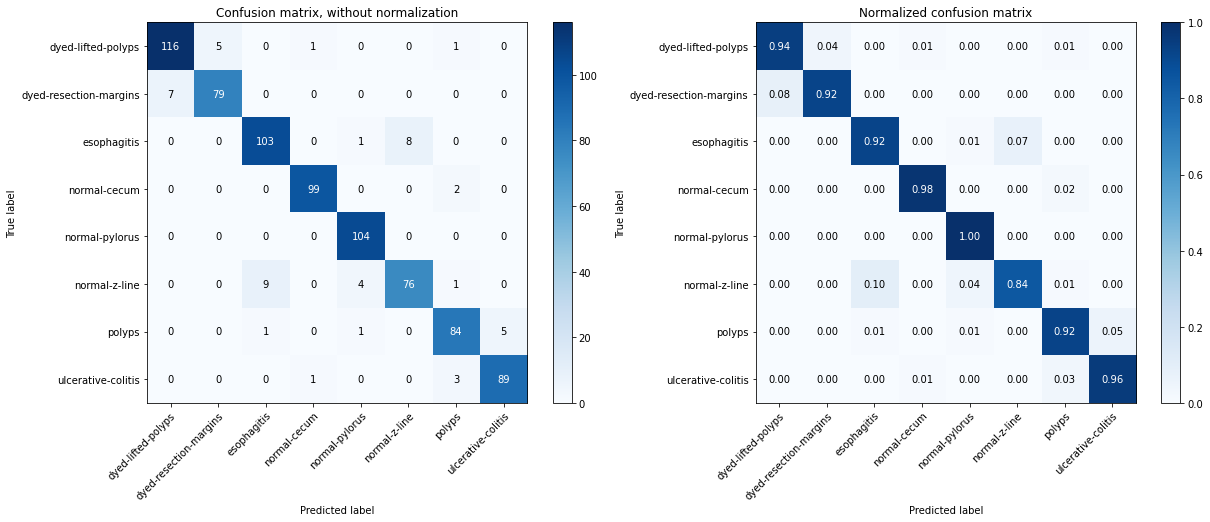

In [ ]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))


### **3.3. Predicion au hasard**

Prédire des images choisies au hasard et compare la prédiction avec la vérité terrain

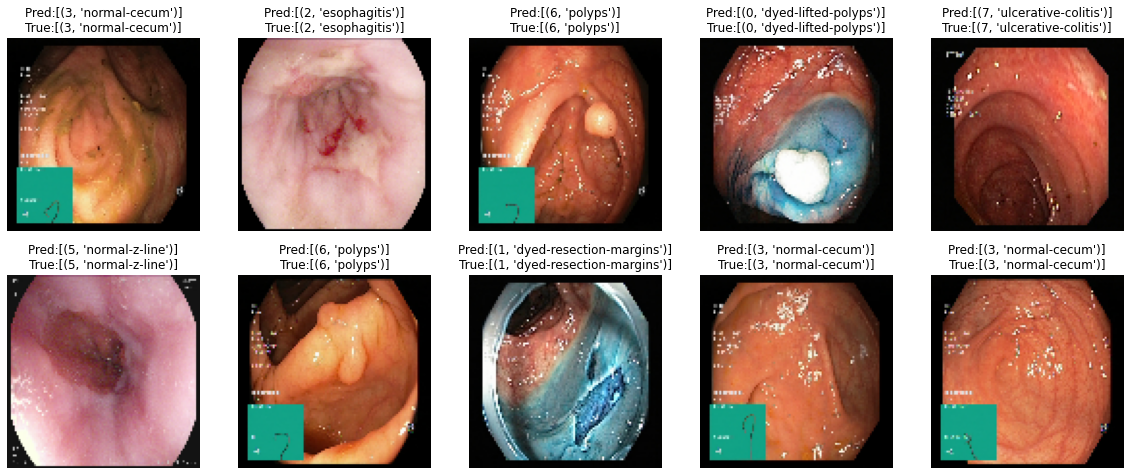

In [ ]:
def predict_categorie_img(img, model, categories):
    """
        predire la classe d'une image donnee

    Args:
        img (numpay): l'image donnee
        model (_type_): le model utilise pour la prediction
        categories (list): liste des classes

    Raises:
        TypeError: erreur si l'image n'est pas en RGB (image_dim < 3)

    Returns:
        int: l'index de la classes predie
        str: la classe predie
    """
    try:
        img = img[None, :, :, :]
    except:
        raise TypeError("test image dimension != 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]





plt.figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = X[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()
